# NLP for Disaster Tweets Analysis & Prediction

## Introduction

This project is dedicated to the exploration of Natural Language Processing (NLP) techniques to determine whether tweets are related to real disasters. The dataset comprises two essential files: `train.csv` and `test.csv`, with a sample submission file, `sample_submission.csv`, illustrating the correct format for result submissions.

## Dataset Description

### Files Needed
- **train.csv:** Training set containing tweet text, keywords, location, and target labels.
- **test.csv:** Test set with tweet text, keywords, and location information.
- **sample_submission.csv:** Sample file demonstrating the correct submission format.

### Data Format
Each sample in the training and test sets includes:
- The text of a tweet.
- A keyword from the tweet (which may be blank).
- The location from which the tweet was sent (may also be blank).

### Prediction Target
The primary objective is to predict whether a given tweet is about a real disaster. If it is, the prediction is coded as 1; if not, it is coded as 0.

### The Data Dictionary

| Column    | Description                                              |
|-----------|----------------------------------------------------------|
| `id`      | Unique identifier for each tweet                         |
| `text`    | The content of the tweet                                 |
| `location`| Location from which the tweet was sent (may be blank)    |
| `keyword` | A specific keyword from the tweet (may be blank)         |
| `target`  | In train.csv only, denotes if the tweet is about a real disaster (1) or not (0) |

## Getting Started

1. **Obtain the required files:**
   - Download `train.csv`, `test.csv`, and `sample_submission.csv`.

2. **Explore the dataset:**
   - Utilize the provided files to comprehend the structure and contents of the data.

3. **Run NLP models:**
   - Employ NLP techniques to predict whether tweets are about real disasters.

4. **Submit Predictions:**
   - Utilize insights gained from NLP models to predict the target for tweets in the test set.

## Contribution

This project encourages contributions from the community. Feel free to submit pull requests, share insights, or engage in discussions in the project's forum.

## Acknowledgements

The dataset for this project is sourced from [Kaggle](https://www.kaggle.com/), and heartfelt gratitude is extended to the contributors for making this valuable data available for analysis.

## Let's get started with our PRRRRRRRRRRREDICTION!


#### Importing required libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import missingno as msno 

import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict, Counter

plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import gc

import operator
import joblib

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


#### Load the dataset

In [75]:
# import data from CSV after downloading from Kaggle 
# https://www.kaggle.com/competitions/nlp-getting-started/overview
path = ('/Users/stevenschepanski/Documents/Projects/NLP_Tweets/')
tweet= pd.read_csv(path + 'data/train.csv')
test=pd.read_csv(path + 'data/test.csv')

### 1. Data Exploration

In [76]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [77]:
print('The train data has', tweet.shape[0],'rows and', tweet.shape[1], 'columns.')
print('The test data has', test.shape[0],'rows and', test.shape[1], 'columns.')

The train data has 7613 rows and 5 columns.
The test data has 3263 rows and 4 columns.


In [78]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


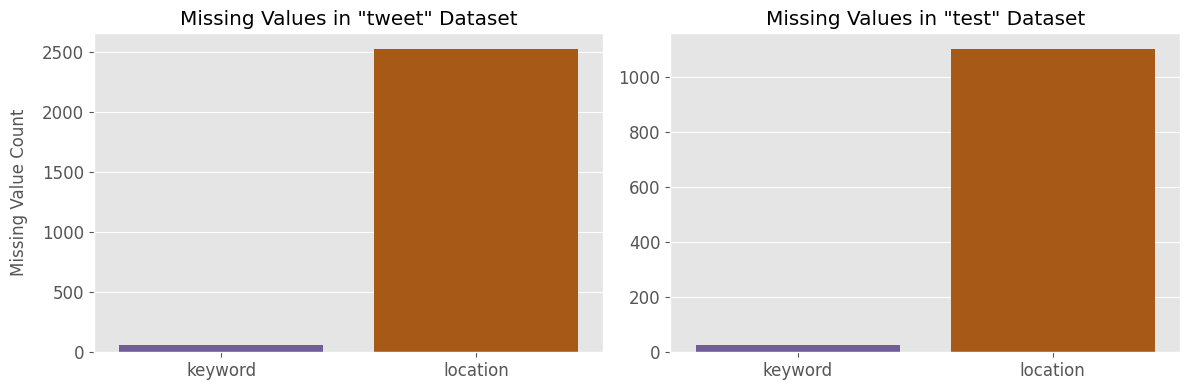

In [80]:
# Custom colours
violet = (108/255, 84/255, 158/255)  # RGB(108, 84, 158)
dark_orange = (191/255, 87/255, 0/255)  # RGB(191, 87, 0)

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)

# Plot for "tweet" dataset
sns.barplot(x=['keyword', 'location'], y=tweet[['keyword', 'location']].isnull().sum().values, ax=axes[0],
            palette={'keyword': violet, 'location': dark_orange})
axes[0].set_title('Missing Values in "tweet" Dataset')

# Plot for "test" dataset
sns.barplot(x=['keyword', 'location'], y=test[['keyword', 'location']].isnull().sum().values, ax=axes[1],
            palette={'keyword': violet, 'location': dark_orange})
axes[1].set_title('Missing Values in "test" Dataset')

# Adjust labels and show the plot
axes[0].set_ylabel('Missing Value Count', size=12, labelpad=10)
for ax in axes:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()



In [81]:
# Calculate missing value ratios
tweet_missing_ratio = tweet[['keyword', 'location']].isnull().mean()
test_missing_ratio = test[['keyword', 'location']].isnull().mean()

# Print missing value ratios
print("Missing Value Ratios in 'tweet' Dataset:")
print(tweet_missing_ratio)

print("\nMissing Value Ratios in 'test' Dataset:")
print(test_missing_ratio)


Missing Value Ratios in 'tweet' Dataset:
keyword     0.008013
location    0.332720
dtype: float64

Missing Value Ratios in 'test' Dataset:
keyword     0.007968
location    0.338645
dtype: float64


In [82]:
print(tweet.duplicated().sum(), 'rows are duplicated.')
print(tweet['id'].duplicated().sum(), 'IDs are duplicated.')
### No entire rows are duplicated, and no project appears twice in the data.

0 rows are duplicated.
0 IDs are duplicated.


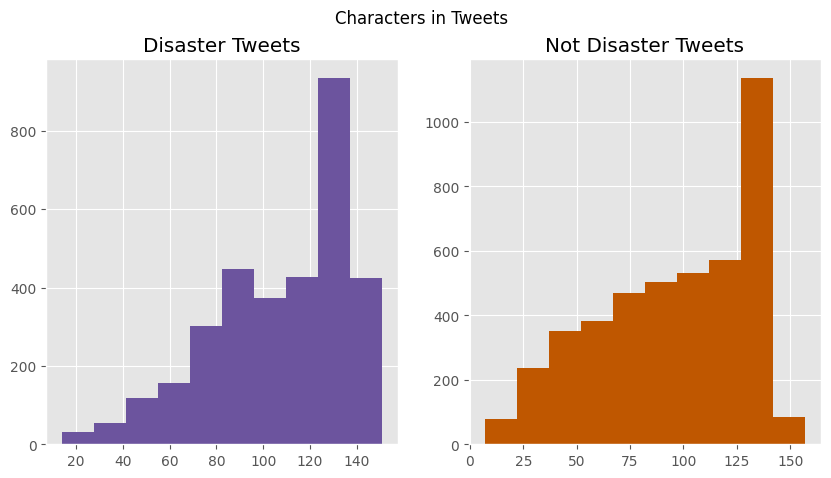

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Disaster tweets
tweet_len_disaster = tweet[tweet['target'] == 1]['text'].str.len()
ax1.hist(tweet_len_disaster, color=custom_colour)
ax1.set_title('Disaster Tweets')

# Not disaster tweets
tweet_len_not_disaster = tweet[tweet['target'] == 0]['text'].str.len()
ax2.hist(tweet_len_not_disaster, color=dark_orange)
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Characters in Tweets')
plt.show()

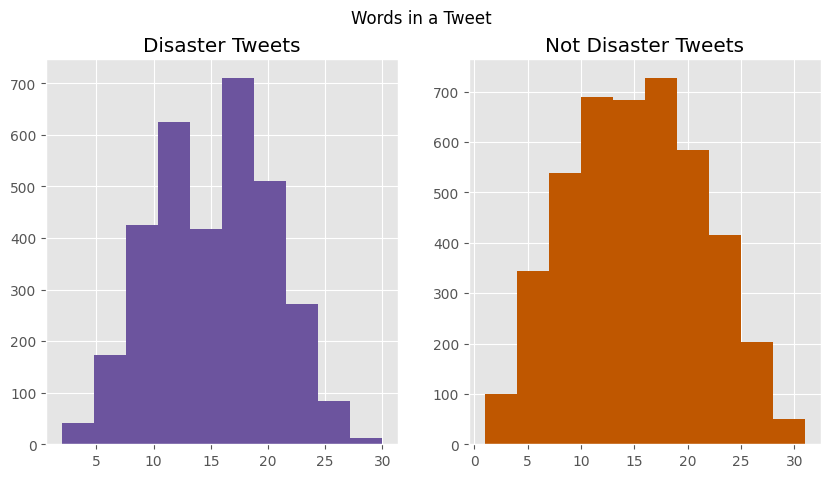

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Disaster tweets
tweet_len_words_disaster = tweet[tweet['target'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len_words_disaster, color=custom_colour)
ax1.set_title('Disaster Tweets')

# Not disaster tweets
tweet_len_words_not_disaster = tweet[tweet['target'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len_words_not_disaster, color=dark_orange)
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Words in a Tweet')
plt.show()

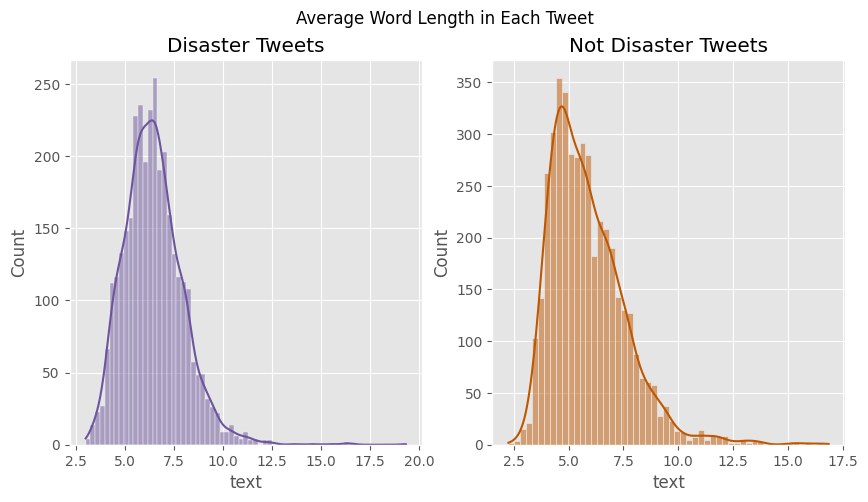

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Disaster tweets
word_disaster = tweet[tweet['target'] == 1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word_disaster.map(lambda x: np.mean(x)), ax=ax1, color=custom_colour, kde=True)
ax1.set_title('Disaster Tweets')

# Not disaster tweets
word_not_disaster = tweet[tweet['target'] == 0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word_not_disaster.map(lambda x: np.mean(x)), ax=ax2, color=dark_orange, kde=True)
ax2.set_title('Not Disaster Tweets')

fig.suptitle('Average Word Length in Each Tweet')
plt.show()

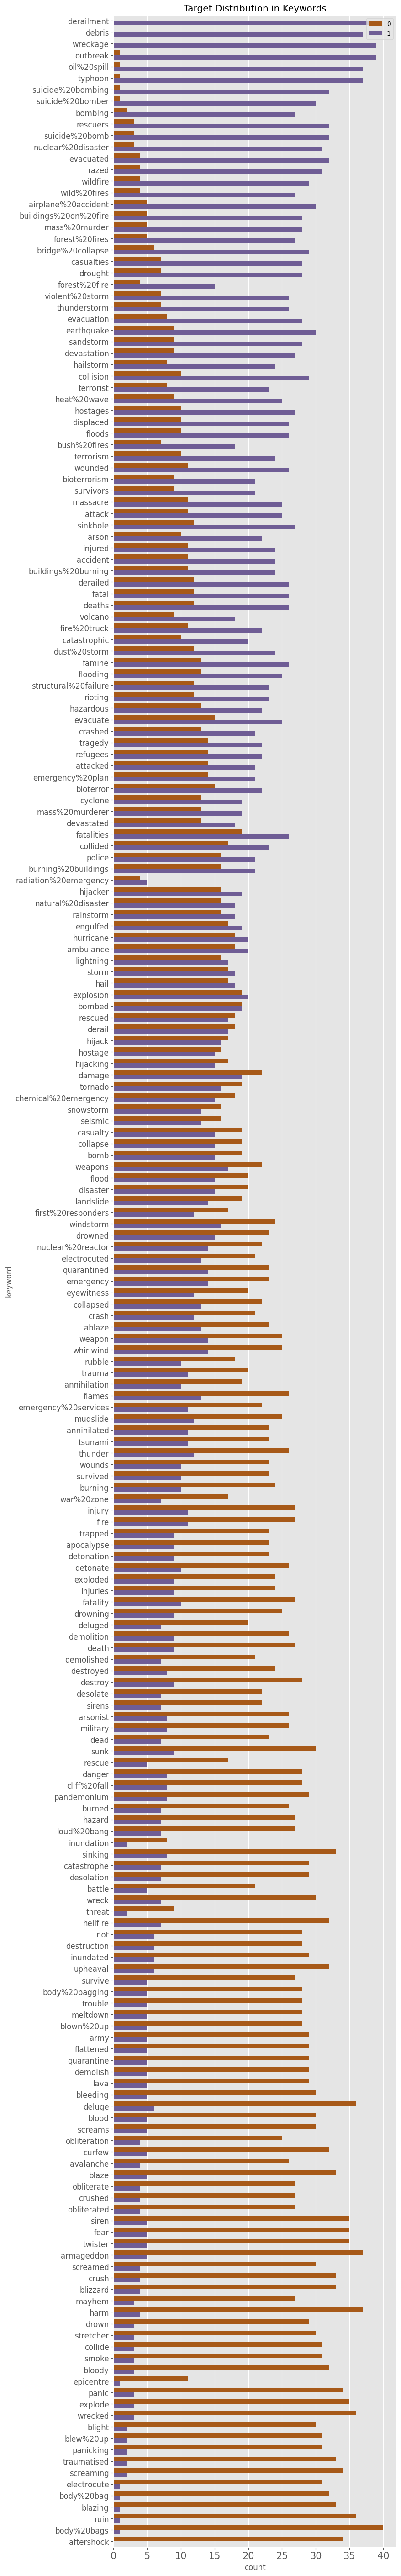

In [86]:
tweet['target_mean'] = tweet.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=tweet.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=tweet.sort_values(by='target_mean', ascending=False)['target'],
              palette={0: dark_orange, 1: violet})

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

tweet.drop(columns=['target_mean'], inplace=True)

In [87]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stevenschepanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


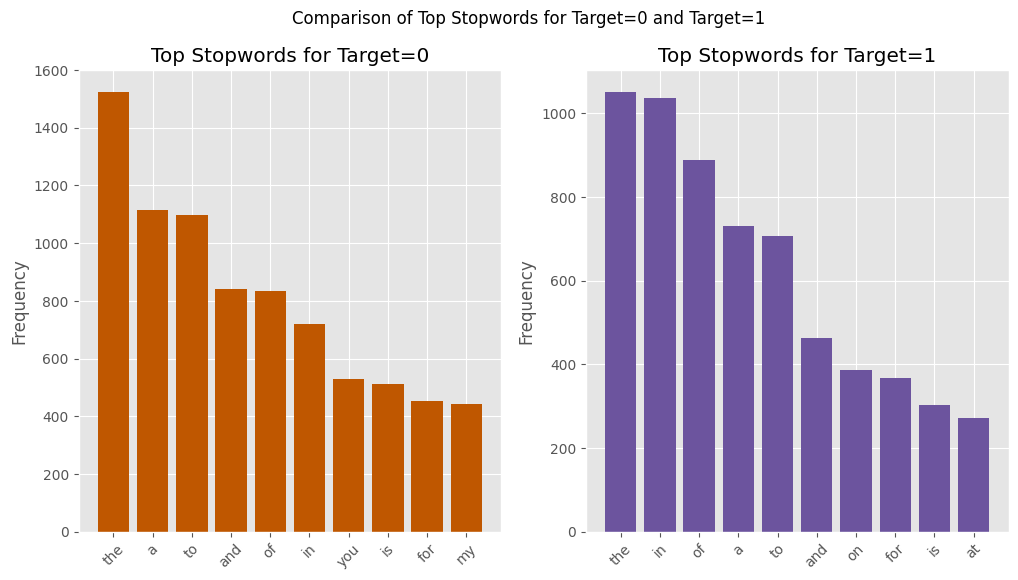

In [88]:
# Download NLTK stopwords
nltk.download('stopwords')

# Define the set of stopwords
stop = set(stopwords.words('english'))

# Create corpuses for target values '0' and '1'
corpus_0 = create_corpus(0)
corpus_1 = create_corpus(1)

# Count stopwords for target value '0'
dic_0 = defaultdict(int)
for word in corpus_0:
    if word in stop:
        dic_0[word] += 1

# Count stopwords for target value '1'
dic_1 = defaultdict(int)
for word in corpus_1:
    if word in stop:
        dic_1[word] += 1

# Get top stopwords for target value '0'
top_0 = sorted(dic_0.items(), key=lambda x: x[1], reverse=True)[:10]

# Get top stopwords for target value '1'
top_1 = sorted(dic_1.items(), key=lambda x: x[1], reverse=True)[:10]

# Unpack top stopwords for plotting
x_0, y_0 = zip(*top_0)
x_1, y_1 = zip(*top_1)

# Create a bar plot comparing top stopwords for target values '0' and '1'
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(x_0, y_0, color=dark_orange)
axes[0].set_title('Top Stopwords for Target=0')
axes[1].bar(x_1, y_1, color=violet)
axes[1].set_title('Top Stopwords for Target=1')

for ax in axes:
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel('Frequency')

fig.suptitle('Comparison of Top Stopwords for Target=0 and Target=1')
plt.show()


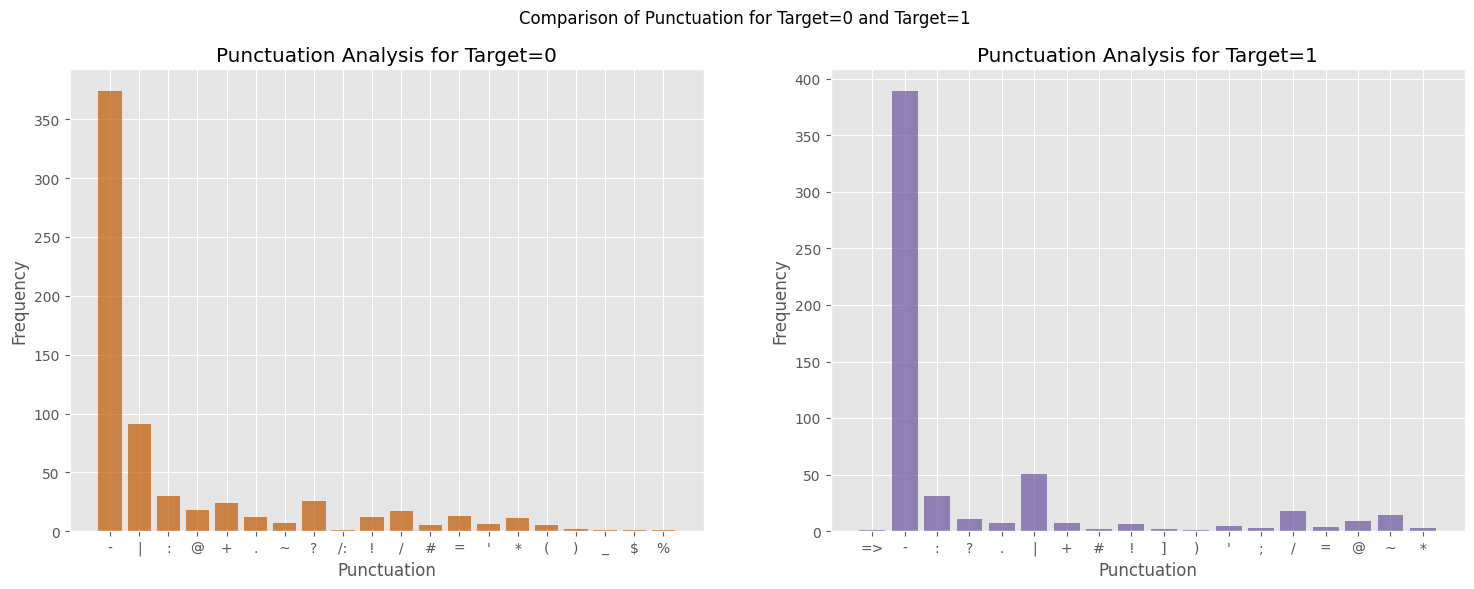

In [89]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Count punctuation occurrences for target value '0'
dic_0_punctuation = defaultdict(int)
special = string.punctuation
for i in corpus_0:
    if i in special:
        dic_0_punctuation[i] += 1

# Count punctuation occurrences for target value '1'
dic_1_punctuation = defaultdict(int)
for i in corpus_1:
    if i in special:
        dic_1_punctuation[i] += 1

# Create bar plots for punctuation for target values '0' and '1'
x_0_punctuation, y_0_punctuation = zip(*dic_0_punctuation.items())
x_1_punctuation, y_1_punctuation = zip(*dic_1_punctuation.items())

# Plot for target value '0'
axes[0].bar(x_0_punctuation, y_0_punctuation, color=dark_orange, alpha=0.7)
axes[0].set_title('Punctuation Analysis for Target=0')
axes[0].set_xlabel('Punctuation')
axes[0].set_ylabel('Frequency')

# Plot for target value '1'
axes[1].bar(x_1_punctuation, y_1_punctuation, color=violet, alpha=0.7)
axes[1].set_title('Punctuation Analysis for Target=1')
axes[1].set_xlabel('Punctuation')
axes[1].set_ylabel('Frequency')

plt.suptitle('Comparison of Punctuation for Target=0 and Target=1')
plt.show()

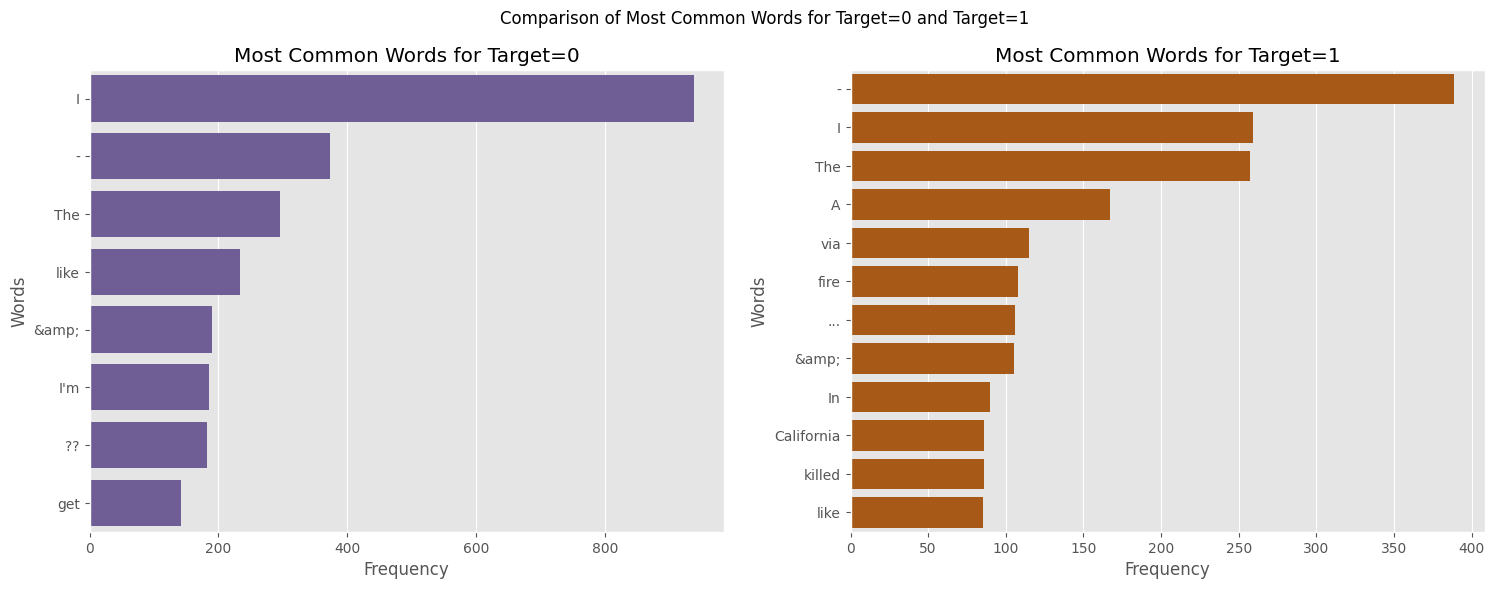

In [90]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Count occurrences for target value '0'
counter_0 = Counter(corpus_0)
most_0 = counter_0.most_common()
x_0 = []
y_0 = []
for word, count in most_0[:40]:
    if word not in stop:
        x_0.append(word)
        y_0.append(count)

# Count occurrences for target value '1'
counter_1 = Counter(corpus_1)
most_1 = counter_1.most_common()
x_1 = []
y_1 = []
for word, count in most_1[:40]:
    if word not in stop:
        x_1.append(word)
        y_1.append(count)

# Plot for target value '0'
sns.barplot(x=y_0, y=x_0, ax=axes[0], color=violet)
axes[0].set_title('Most Common Words for Target=0')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Words')

# Plot for target value '1'
sns.barplot(x=y_1, y=x_1, ax=axes[1], color=dark_orange)
axes[1].set_title('Most Common Words for Target=1')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Words')

plt.suptitle('Comparison of Most Common Words for Target=0 and Target=1')
plt.show()

In [91]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]



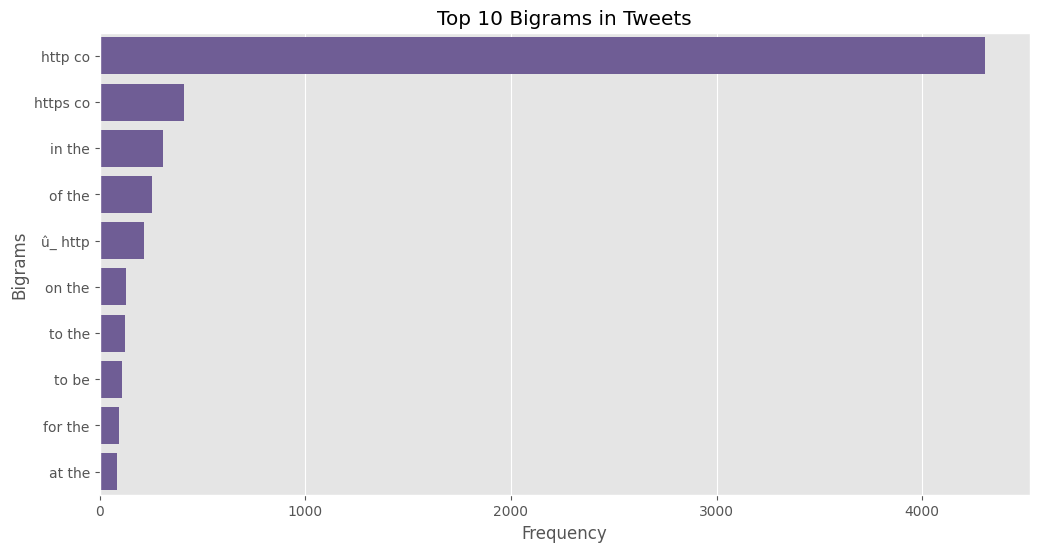

In [92]:
plt.figure(figsize=(12, 6))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))

# Create a horizontal bar plot
sns.barplot(x=y, y=x, color=violet)

plt.title('Top 10 Bigrams in Tweets')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

### 2. Data Preprocessing/Cleaning

In [93]:
# Concatenate 'tweet' and 'test' DataFrames into 'df'
df = pd.concat([tweet, test])
print(df.shape)

(10876, 5)


In [94]:
# Example URL removal function
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [95]:
# Apply URL removal to the 'text' column
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [96]:
# Example HTML tag removal function
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

In [97]:
# Apply HTML tag removal to the 'text' column
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [98]:
# Example emoji removal function
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [99]:
# Apply emoji removal to the 'text' column
df['text'] = df['text'].apply(lambda x: remove_emoji(x))


In [100]:
# Example punctuation removal function
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [101]:
# Apply punctuation removal to the 'text' column
df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [102]:
from spellchecker import SpellChecker
# Example spell correction function
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [103]:
# Example usage of spell correction function
text = "corect me plese"
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_word = spell.correction(word)
            if corrected_word:
                corrected_text.append(corrected_word)
            else:
                corrected_text.append(word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [104]:
# apply spell correction to the 'text' column
df['text'] = df['text'].apply(lambda x: correct_spellings(x))

In [105]:
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0


In [106]:
# Identify mislabeled samples
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
mislabeled_texts = df_mislabeled.index.tolist()

# Relabel tweets
for text in mislabeled_texts:
    # Check if there are any instances of the text in the DataFrame
    if df[df['text'] == text].shape[0] > 0:
        # Assign the majority target value for each unique text
        majority_target = df.loc[df['text'] == text, 'target'].mode().values[0]
        df.loc[df['text'] == text, 'target_relabeled'] = majority_target

# Display the tweets that were relabeled
print("Tweets that were relabeled:")
print(mislabeled_texts)

# Verify the changes
print(df[['text', 'target', 'target_relabeled']].loc[df['target_relabeled'].notnull()])


Tweets that were relabeled:
['Drunk Meals 101 What To Cook When Youre Totally Obliterated', 'foodscare offers2go NestleIndia slips into loss after Magginoodle ban unsafe and hazardous for humanconsumption', 'POTUS StrategicPatience is a strategy for Genocide refugees IDP Internally displaced people horror etc', 'Hellfire We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it islam', 'Hellfire is surrounded by desires so be careful and don\x89Ûªt let your desires control you Afterlife', 'accionempresa China\x89Ûªs stock market crash this summer has sparked interest from bargain hunt gerenciatodos i', 'Earthquake drill', 'Mmmmmm Im burning Im burning buildings Im building Oooooohhhh oooh ooh', 'The Dress Memes Have Officially Exploded On The Internet', 'that horrible sinking feeling when you\x89Ûªve been at home on your phone for a while and you realise its been on 3G this whole time', 'Owner of ChicagoArea Gay Bar Admits to Arson Scheme LG

In [107]:
from tqdm import tqdm

def load_glove_embedding(file_path):
    embedding_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    return embedding_dict

def create_embedding_matrix(embedding_dict, tokenizer, max_len, num_words):
    embedding_matrix = np.zeros((num_words, len(list(embedding_dict.values())[0])))
    for word, i in tqdm(tokenizer.word_index.items()):
        if i > num_words:
            continue
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
    return embedding_matrix

def prepare_data_with_embedding(df, glove_file, max_len=50):
    corpus = create_corpus(df)
    
    # Tokenization and Padding
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    tweet_pad = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')
    
    # Word Index and Embedding Matrix
    word_index = tokenizer.word_index
    num_words = len(word_index) + 1
    embedding_dict = load_glove_embedding(glove_file)
    embedding_matrix = create_embedding_matrix(embedding_dict, tokenizer, max_len, num_words)
    
    return tweet_pad, embedding_matrix, num_words


In [110]:
def create_corpus(df):
    corpus = []
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


In [112]:
# Paths to GloVe embeddings
glove_files = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt']
embedding_matrices = []

# Loop through each GloVe file
for glove_file in glove_files:
    # Define the path to the GloVe file
    glove_path = os.path.join(path, 'models', glove_file)
    
    # Initialize embedding dictionary
    embedding_dict = {}
    
    # Read the GloVe file
    with open(glove_path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    # Create corpus for the specific file
    corpus = create_corpus(df)

    # Tokenization and Padding
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)
    max_len = 50  # or the desired value for max_len
    tweet_pad = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

    # Word Index and Embedding Matrix for the specific file
    word_index = tokenizer.word_index
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, len(list(embedding_dict.values())[0])))
    
    for word, i in tqdm(word_index.items()):
        if i > num_words:
            continue

        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec
    
    # Append the embedding matrix to the list
    embedding_matrices.append(embedding_matrix)

100%|██████████| 21992/21992 [00:00<00:00, 519475.20it/s]


MODEL

In [122]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten, Concatenate

# Define the neural network
model = Sequential()


In [129]:
# Create a list to hold the input layers
input_layers = []

# Add multiple Embedding layers using different embedding matrices
embedding_dims = [len(list(embedding_matrix[0])) for embedding_matrix in embedding_matrices]

embedding_layers = []
for i, embedding_matrix in enumerate(embedding_matrices):
    embedding_dim = embedding_dims[i]
    # Define an input layer for each embedding layer
    input_layer = Input(shape=(max_len,), name=f'input_layer_{i}')
    embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len,
                                weights=[embedding_matrix], trainable=False, name=f'embedding_layer_{i}')
    
    # Connect the input layer to the embedding layer
    embedded_input = embedding_layer(input_layer)
    
    # Append the input layer to the list
    input_layers.append(input_layer)
    embedding_layers.append(embedded_input)


In [130]:
# Concatenate the output of all Embedding layers
concatenated_embedding = Concatenate(name='concatenated_embedding')(embedding_layers)


In [133]:
# Flatten the output of each Embedding layer
flattened_outputs = [Flatten(name=f'flatten_{i}')(embedded_input) for i, embedded_input in enumerate(embedding_layers)]


In [137]:
from keras.layers import Reshape

# Add other layers as needed
lstm_units = 100

# Concatenate the flattened outputs
concatenated_flattened = Concatenate(name='concatenated_flattened')(flattened_outputs)

# Reshape the concatenated output for LSTM layer
num_embedding_matrices = len(embedding_matrices)
reshaped_concatenated = Reshape((num_embedding_matrices, -1), name='reshaped_concatenated')(concatenated_flattened)

# Add an LSTM layer
lstm_layer = LSTM(units=lstm_units, return_sequences=True, name='lstm_layer')(reshaped_concatenated)

# Flatten the output of the LSTM layer
flattened_lstm_output = Flatten(name='flattened_lstm_output')(lstm_layer)

# Add a Dense output layer
output_layer = Dense(units=1, activation='sigmoid', name='output_layer')(flattened_lstm_output)

# Create the model
model = Model(inputs=input_layers, outputs=output_layer)

ValueError: Exception encountered when calling layer "reshaped_concatenated" (type Reshape).

total size of new array must be unchanged, input_shape = [17500], output_shape = [3, -1]

Call arguments received by layer "reshaped_concatenated" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 17500), dtype=float32)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Print the model summary
model.summary()

### Model 1 - Predicting `Pledged`

In this phase of the project, our primary goal is to predict the pledged amount for Kickstarter projects. We are exploring various input features such as campaign duration, subcategory, goal, and launch date to understand their influence on the pledged amount.

#### Input Features

1. **Campaign Duration**
2. **Subcategory**
3. **Goal**
4. **Launch Date**

#### Baseline Models

To establish a foundation for our prediction task, we begin with the following baseline models:

1. **Dummy Regressor with Mean Strategy:**
   - This simplistic model considers the mean of the pledged amount as a benchmark. It provides a starting point for comparison and helps us understand the performance of more sophisticated models.

2. **Linear Regression with Only `Goal` as Feature:**
   - A linear regression model is implemented with the goal as the sole predictor. This basic model helps us gauge the impact of a single feature on the pledged amount.

#### Rationale

- **Choice of Dummy Regressor:** The Dummy Regressor with a mean strategy is chosen to establish a benchmark that represents the simplest possible prediction. It serves as a reference point for evaluating the effectiveness of more complex models.

- **Linear Regression with `Goal`:** This straightforward model with only the goal as a predictor allows us to explore the relationship between the campaign goal and the pledged amount. It helps us identify whether a linear relationship exists and if additional features are necessary for improved predictions.

#### Final Model

For the final model, we plan to implement the Random Forest Regressor. However, the primary focus at this stage is on understanding the dynamics of predicting the pledged amount, exploring the significance of different features, and setting the groundwork for more advanced models in subsequent iterations.


#### Feature Selection

In [ ]:
columns_keepX = ['Duration', 'Subcategory', 'Goal', 'LaunchYear', 'LaunchMonth', \
                'LaunchDay', 'LaunchDayOfWeek']
columns_keepY = ['Pledged']

X = df[columns_keepX]
y = df[columns_keepY]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=X['Subcategory'])

#### Baseline Model

In [ ]:
# Dummy Regressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_r2 = round(dummy.score(X_train, y_train), 2)
dummy_mse = round(mean_squared_error(y_train, dummy.predict(X_train), squared=False), 2)

print('For mean R2 score in the dummy model:', dummy_r2)
print('For mean RMSE score in the dummy model:', dummy_mse)


In [ ]:
# Linear Regression
Xnew_train = pd.DataFrame(X_train['Goal'])
lr = LinearRegression()
lr.fit(Xnew_train, y_train)
lr_r2 = round(lr.score(Xnew_train, y_train), 2)
lr_rmse = round(mean_squared_error(y_train, lr.predict(Xnew_train), squared=False), 2)

print('Linear Regression R2 score:', lr_r2)
print('Linear Regression RMSE score:', lr_rmse)

In [ ]:
# quick function to print main metrics of a model
def print_metrics(model_name, estimator, dummy, X_train, y_train, X_test, y_test):
    print(model_name.upper())
    print('Train R^2: {:.4f}'.format(estimator.score(X_train, y_train)))
    print('Train RMSE: {:.2f}'.format(mean_squared_error(y_train, estimator.predict(X_train), squared=False)))

    print('Test R^2: {:.4f}'.format(estimator.score(X_test, y_test)))
    print('Test RMSE: {:.2f}'.format(mean_squared_error(y_test, estimator.predict(X_test), squared=False)))
    print('Difference RMSE to Dummy: {:.2f}'.format(mean_squared_error(y_test, dummy.predict(X_test), squared=False) - \
                                                    mean_squared_error(y_test, estimator.predict(X_test), squared=False)))

    print('Dummy R^2: {:.4f}'.format(dummy.score(X_test, y_test)))
    print('Dummy RMSE: {:.2f}'.format(mean_squared_error(y_test, dummy.predict(X_test), squared=False)))


#### Feature Engineering

#### Pipeline Planning

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Subcategory'])
], remainder='passthrough')

pipeline_model = Pipeline([
    ('ct', ct),
    ('rf', RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1))
])

In [ ]:
# pledged
pipeline_model.fit(X_train, y_train)

In [ ]:
print_metrics('Random Forest Target Pledged', pipeline_model, dummy, X_train, y_train, X_test, y_test) 

### Model 2 - Predicting `Backers`
In this phase, our objective is to predict the number of backers a Kickstarter project will attract. We consider several input features, including campaign duration, subcategory, goal (pledged amount), and launch date.

#### Input Features

1. **Campaign Duration**
2. **Subcategory**
3. **Goal (Pledged Amount)**
4. **Launch Date**

#### Baseline Models

To establish a baseline for predicting the number of backers, we employ the following models:

1. **Dummy Regressor with Mean Strategy (Dummy2):**
   - This dummy regressor predicts the mean number of backers for all projects. It provides a starting point for assessing the performance of more sophisticated models.

#### Final Models

For the final models, we explore two different regressors:

1. **Random Forest Regressor:**
   - A random forest regressor is employed to capture non-linear relationships and complexities within the data.

2. **XGBoost Regressor:**
   - The XGBoost regressor is another ensemble learning model that excels in capturing intricate patterns and relationships in the data.

#### Rationale

- **Choice of Dummy Regressor:** Similar to the previous model, the Dummy Regressor with a mean strategy is chosen to create a baseline for comparison. Its negative R2 score and MSE help us appreciate the performance improvements achieved by more sophisticated models.

- **Random Forest and XGBoost Regressors:** These ensemble models are selected for their ability to handle complex relationships and patterns within the data. Their performance metrics, including R2 score and MSE, will be assessed to determine the effectiveness of predicting the number of backers.

#### Conclusion

While presenting the results, the emphasis is on understanding the dynamics of predicting backers and assessing the impact of different features on the outcome.


#### Feature Selection

In [ ]:
columns_keepX2 = ['Duration', 
                  'Subcategory', 
                  'Goal', 
                  'LaunchYear', 
                 'LaunchMonth',
                'LaunchDay', 
                'LaunchDayOfWeek', 
                'Pledged'
                ]
columns_keepY2 = ['Backers']

# df2 = df[df['Pledged'] >= df['Goal']]
# df = df.copy()
# df = df[df['State'] == 'Successful']
X2 = df[columns_keepX2]
y2 = df[columns_keepY2]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


#### Baseline Model

In [ ]:
# Dummy Regressor 2
dummy2 = DummyRegressor(strategy='mean')
dummy2.fit(X2_train, y2_train)
dummy2_r2 = round(dummy2.score(X2_test, y2_test), 2)
dummy2_mse = round(mean_squared_error(y2_test, dummy2.predict(X2_test), squared=False), 2)

print('R2 of Dummy2:', dummy2_r2)
print('MSE of Dummy2:', dummy2_mse)


#### Pipeline Planning

In [ ]:
# using column transformer from model 1
pipeline_model2 = Pipeline([
    ('ct', ct), # from Model 1, no changes (for now)
    ('rf', RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1))
])

#### Training the Model

In [ ]:
# backers
pipeline_model2.fit(X2_train, y2_train)

In [ ]:
print_metrics('Random Forest Target Backers', pipeline_model2, dummy2, X2_train, y2_train, X2_test, y2_test)

In [ ]:
pipeline_model3 = Pipeline([
    ('ct', ct),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True))
])

In [ ]:
pipeline_model3.fit(X2_train, y2_train)

In [ ]:
print_metrics('XGBoost for Backers', pipeline_model3, dummy2, X2_train, y2_train, X2_test, y2_test)

In [ ]:
# print_metrics('Random Tree for Pledged', pipeline_model, dummy, X_train, y_train, X_test, y_test)
print_metrics('Random Tree for Backers', pipeline_model2, dummy2, X2_train, y2_train, X2_test, y2_test)
print_metrics('XGBoost for Backers', pipeline_model3, dummy2, X2_train, y2_train, X2_test, y2_test)

#### Model Optimization

#### XGBoost Optimization

In [ ]:
pipeline_model3.get_params();

In [ ]:
param_grid = {
    # # Specify the booster type, which can be 'gbtree', 'gblinear', or 'dart'.
    'xgb__booster': ['gbtree', 'gblinear', 'dart'], #from pipline element: ('xgb', XGBRegressor(random_state=42, n_jobs=-1, enable_categorical=True))

    # # Enable or disable categorical feature support.
    'xgb__enable_categorical': [True, False],

    # # Fraction of features to be randomly sampled for each tree.
    'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],

    # # Step size shrinkage to prevent overfitting.
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3],

    # # Maximum depth of a tree. Controls the maximum depth of each tree in the ensemble.
    'xgb__max_depth': [3, 4, 5, 6, 7, 8, 9],

    # # Number of boosting rounds (trees) to be run.
    'xgb__n_estimators': [50, 100, 200, 300, 400],
}


In [ ]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=pipeline_model3,
    param_distributions=param_grid,
    n_iter=10,  # Number of random parameter combinations to try
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1,  # Use -1 to use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [ ]:
# Fit the RandomizedSearchCV object to your data
random_search.fit(X2_train, y2_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", -random_search.best_score_)

In [ ]:
# visualize residuals
y_pred = pipeline_model2.predict(X2_test)
y_pred.max()
display = PredictionErrorDisplay(y_true=y2_test, y_pred=y_pred.reshape(-1, 1))
display.plot()

#### Random Forest Optimization

In [ ]:
cf2 = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Subcategory']),
    ('scale', RobustScaler(), ['Pledged'])
], remainder='passthrough')

pipeline_model4 = Pipeline([
    ('cf', cf2),
    ('rt', RandomForestRegressor(max_depth=10, n_estimators=100, random_state=42, n_jobs=-1))
])

In [ ]:
pipeline_model4.fit(X2_train, y2_train)

In [ ]:
# print_metrics('Random Tree for Pledged', pipeline_model, dummy, X_train, y_train, X_test, y_test)
print_metrics('Random Forest for Backers', pipeline_model2, dummy2, X2_train, y2_train, X2_test, y2_test)
print_metrics('XGBoost for Backers', pipeline_model3, dummy2, X2_train, y2_train, X2_test, y2_test)
print_metrics('Random Forest for Backers Scaled Pledged', pipeline_model4, dummy2, X2_train, y2_train, X2_test, y2_test)

In [ ]:
pipeline_model4.get_params()

In [ ]:
param_grid = {
              'rt__max_depth': range(5, 100, 10),
              'rt__n_estimators': range(100, 1000, 100),
              'rt__max_features': [1, 'sqrt'],
              'rt__criterion': ['absolute_error'],
              'rt__max_samples': [0.5, 0.75, 1.0],
              }
rs2 = RandomizedSearchCV(
    estimator=pipeline_model4,
    param_distributions=param_grid,
    n_iter=100,  # Number of random parameter combinations to try
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1,  # Use -1 to use all available CPU cores
    random_state=42  # Set a random seed for reproducibility
)

In [ ]:
rs2.fit(X2_train, y2_train)

In [ ]:
rs2.best_params_


# Conclusion